    t        beta(t)
 0.0000    0.000000
 0.1000    0.052433
 0.2000    0.078025
 0.3000    0.100476
 0.4000    0.122186
 0.5000    0.144414
 0.6000    0.168327
 0.7000    0.195556
 0.8000    0.229278
 0.9000    0.278757
 1.0000    1.000000


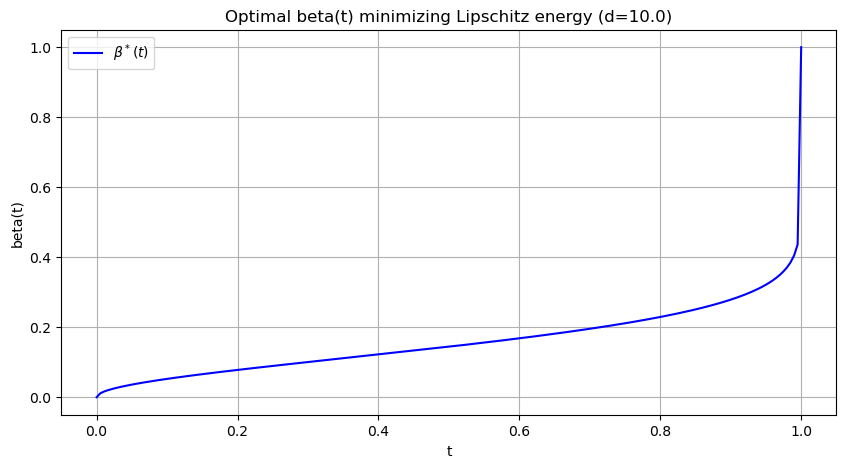

In [2]:
import numpy as np
from math import exp, sqrt, pi, cosh
from scipy.integrate import quad
from scipy.interpolate import interp1d
from functools import lru_cache

#C(beta) = E[sech^4(beta * d * x)] under the
#mixture 0.5*N(beta*d, 1) + 0.5*N(-beta*d, 1).
#G(beta) = beta^2 * d^4 * C(beta).
#H(beta) = \int_0^beta sqrt(G(u)) du.
#optimal path satisfies t = H(beta) / H(1).

def normal_pdf(x, mean=0.0, var=1.0):
    """Gaussian pdf N(x; mean, var=1)."""
    return (1.0 / np.sqrt(2.0 * pi * var)) * np.exp(-(x - mean)**2/(2*var))

def sech4(z):
    """sech^4(z) = 1 / cosh^4(z)."""
    return 1.0 / (cosh(z)**4)

def C_of_beta(beta, d):
    """
    C(beta) = expectation of sech^4(beta*d*x) under
              0.5*N(beta*d,1) + 0.5*N(-beta*d,1).
    """
    if beta == 0.0:

        return 1.0

    def integrand_plus(x):
        return normal_pdf(x, mean=+beta*d, var=1.0) * sech4(beta*d*x)

    def integrand_minus(x):
        return normal_pdf(x, mean=-beta*d, var=1.0) * sech4(beta*d*x)

    # Integrate from e.g. -7..+7 to approximate infinite limits:
    plus_part, _  = quad(integrand_plus, -7.0, 7.0)
    minus_part, _ = quad(integrand_minus, -7.0, 7.0)

    return 0.5*plus_part + 0.5*minus_part

@lru_cache(None)
def G_of_beta(beta, d):
    """G(beta) = beta^2 * d^4 * C_of_beta(beta, d)."""
    return (beta**2) * (d**4) * C_of_beta(beta, d)

def H_of_beta(beta, d):
    """
    H(beta) = integral from 0 to beta of sqrt(G(u)) du.
    We'll do a numeric integration. For speed, we might also
    tabulate or use lru_cache.
    """
    # We'll define an integrand:
    def integrand(u):
        return sqrt(G_of_beta(u, d))
    val, _ = quad(integrand, 0.0, beta)
    return val

#-----------------------------------------------------------------------------
# 2) "Invert" H to get beta as a function of t in [0,1].
#    We do this by tabulating H(u)/H(1) for u in [0,1], then invert via interpolation.

def build_beta_of_t(d, num_points=200):
    """
    Returns a function beta(t) for t in [0,1] that solves:
       t = H(beta) / H(1).
    We'll discretize beta in [0,1], compute H(beta), then
    form an interpolant for t->beta.
    """
    # First, compute H(1):
    H1 = H_of_beta(1.0, d)
    if H1 == 0.0:
        return lambda t: t  # trivial identity if d=0
    betas = np.linspace(0.0, 1.0, num_points)
    Hvals = np.array([H_of_beta(u, d) for u in betas])
    tvals = Hvals / H1  # t = H(u)/H(1)

    #invert by building an interpolant t -> beta:

    beta_of_t_fn = interp1d(tvals, betas, kind='cubic')
    return beta_of_t_fn


if __name__ == "__main__":

    d = 10.0
    beta_of_t = build_beta_of_t(d, num_points=200)

    print("    t        beta(t)")
    for t_test in np.linspace(0.0, 1.0, 11):
        b_approx = beta_of_t(t_test)
        print(f"{t_test:7.4f}   {b_approx:9.6f}")


    import matplotlib.pyplot as plt
    ts_fine = np.linspace(0.0, 1.0, 200)
    betas_fine = beta_of_t(ts_fine)
    np.save('beta.npy', betas_fine)
    plt.figure(figsize=(10, 5))
    plt.plot(ts_fine, betas_fine, 'b-', label=r'$\beta^*(t)$')
    plt.xlabel("t")
    plt.ylabel("beta(t)")
    plt.title(f"Optimal beta(t) minimizing Lipschitz energy (d={d})")
    plt.grid(True)
    plt.legend()
    plt.show()


    t        beta(t)
 0.0000    0.000000
 0.1000    0.136267
 0.2000    0.200374
 0.3000    0.255032
 0.4000    0.306725
 0.5000    0.358699
 0.6000    0.413740
 0.7000    0.475499
 0.8000    0.550777
 0.9000    0.658567
 1.0000    1.000000


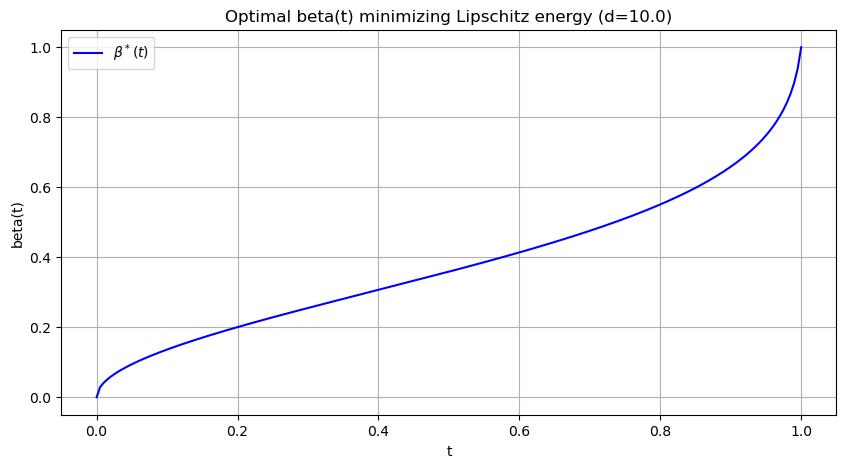

In [11]:
import numpy as np
from math import exp, sqrt, pi, cosh
from scipy.integrate import quad
from scipy.interpolate import interp1d
from functools import lru_cache

k = 1

def normal_pdf(x, mean=0.0, var=1.0):
    """Gaussian pdf N(x; mean, var=1)."""
    return (1.0 / np.sqrt(2.0 * pi * var)) * np.exp(-(x - mean)**2/(2*var))

def sech4(z):
    """sech^4(z) = 1 / cosh^4(z)."""
    return 1.0 / (cosh(z)**4)

def C_of_beta(beta, d, p = 0.5):
    """
    C(beta) = expectation of sech^4(beta*d*x) under
              0.5*N(beta*d,1) + 0.5*N(-beta*d,1).
    """
    if beta == 0.0:

        return 1.0

    def integrand_plus(x):
        return normal_pdf(x, mean=+beta*d, var=1.0) * sech4(beta*d*x)

    def integrand_minus(x):
        return normal_pdf(x, mean=-beta*d, var=1.0) * sech4(beta*d*x)

    # Integrate from e.g. -7..+7 to approximate infinite limits:
    plus_part, _  = quad(integrand_plus, -7.0, 7.0)
    minus_part, _ = quad(integrand_minus, -7.0, 7.0)

    return p*plus_part + (1-p)*minus_part

@lru_cache(None)
def G_of_beta(beta, d, p = 0.5):
    """G(beta) = beta^2 * d^4 * C_of_beta(beta, d)."""
    return (beta**2) * (d**4) * C_of_beta(beta, d, p = p)

def H_of_beta(beta, d, p = 0.5):
    """
    H(beta) = integral from 0 to beta of sqrt(G(u)) du.
    We'll do a numeric integration. For speed, we might also
    tabulate or use lru_cache.
    """
    # We'll define an integrand:
    def integrand(u):
        return sqrt(G_of_beta(u, d, p = p))
    val, _ = quad(integrand, 0.0, beta)
    return val

def H_of_beta(beta, d, k = 1, p = 0.5):
    def integrand(u):
        return (u) * C_of_beta(u, d, p = p) ** (1/(2*k))
    val, _ = quad(integrand, 0.0, beta)
    return val

#-----------------------------------------------------------------------------
# 2) "Invert" H to get beta as a function of t in [0,1].
#    We do this by tabulating H(u)/H(1) for u in [0,1], then invert via interpolation.

def build_beta_of_t(d, num_points=200, k = 1, p = 0.5):
    """
    Returns a function beta(t) for t in [0,1] that solves:
       t = H(beta) / H(1).
    We'll discretize beta in [0,1], compute H(beta), then
    form an interpolant for t->beta.
    """
    # First, compute H(1):
    H1 = H_of_beta(1.0, d, k = k, p = p)
    if H1 == 0.0:
        return lambda t: t  # trivial identity if d=0
    betas = np.linspace(0.0, 1.0, num_points)
    Hvals = np.array([H_of_beta(u, d, k = k, p = p) for u in betas])
    tvals = Hvals / H1  # t = H(u)/H(1)

    #invert by building an interpolant t -> beta:

    beta_of_t_fn = interp1d(tvals, betas, kind='cubic')
    return beta_of_t_fn


if __name__ == "__main__":

    d = 10.0
    beta_of_t = build_beta_of_t(d, num_points=200, k=5, p = 0.7)

    print("    t        beta(t)")
    for t_test in np.linspace(0.0, 1.0, 11):
        b_approx = beta_of_t(t_test)
        print(f"{t_test:7.4f}   {b_approx:9.6f}")


    import matplotlib.pyplot as plt
    ts_fine = np.linspace(0.0, 1.0, 200)
    betas_fine = beta_of_t(ts_fine)
    np.save('beta.npy', betas_fine)
    plt.figure(figsize=(10, 5))
    plt.plot(ts_fine, betas_fine, 'b-', label=r'$\beta^*(t)$')
    plt.xlabel("t")
    plt.ylabel("beta(t)")
    plt.title(f"Optimal beta(t) minimizing Lipschitz energy (d={d})")
    plt.grid(True)
    plt.legend()
    plt.show()
